*Attention U-Net Based Adversarial Architectures for Chest X-ray Lung Segmentation*\
2020 Gaal, Maga, Lukacs\
[link](https://arxiv.org/pdf/2003.10304.pdf)

# Datasets

## Some publicly available datasets

- [JSRT](https://www.ajronline.org/doi/pdf/10.2214/ajr.174.1.1740071)
	- 247 chest X-rays, 154 have lung nodules. Has lung and heart seg.
	- [Get here](http://db.jsrt.or.jp/eng.php) (register at bottom of page)
- [Montgomery and Shenzhen](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4256233/)
	- Montgomery contains 138 chest X-rays, 80 healthy, 58 tuberculosis. Has lung seg.
	- Shenzhen contains 662 chest X-rays, 326 healthy, 336 tuberculosis. Has lung seg.
	- [Get both here](https://openi.nlm.nih.gov/faq?it=xg#collection). Look for "tuberculosis collection"

That’s 1047 images with lung segmentation label. There are larger datasets that have no segmentation label:

- [NIH ChestX-ray8](https://arxiv.org/abs/1705.02315)
	- 108,948 CXRs of 32,717 patients with eight text-mined disease labels
	- [this might be a way to download](https://nihcc.app.box.com/v/ChestXray-NIHCC)
- [NLST](https://www.nejm.org/doi/10.1056/NEJMoa1102873)
	- There's [this link](https://cdas.cancer.gov/publications/320/), which eventually leads [here](https://cdas.cancer.gov/datasets/nlst/), but I don't see any actual CXR images being made available.
 

### JSRT

See [this guide](JSRT_UsersGuide.pdf) to the data for details.

- `JPCLN***.IMG` for chest lung nodule images, and `JPCNN***.IMG` for non-nodule images. These are important classes to keep in mind for the purpose of proportional train/val/test split.
-  coordinates of the upper left of the image are `(0,0)`
- Image type: 16-bit Unsigned
- Width: 2048 pixels
- Height: 2048 pixels
- Offset to First Image: 0 bytes
- Gap Between Images: 0 bytes

You can load the images using [ImageJ](https://imagej.nih.gov/ij/).
Just import as "RAW" and put in the settings specified by the JSRT guide.

Hmm, stuck on this for now... also where are the segmentations? When I load RAW data into Image J I only see an xray image, and I see no reference to segmentation in the JSRT guide. The JSRT download page doesn't say anything about segmentation labels either.

### Shenzhen

[The readme](NLM-ChinaCXRSet-ReadMe.pdf).

- 336 cases with manifestation of tuberculosis, and 
- 326 normal cases.

- Format: PNG
- Image size varies for each X-ray. It is approximately 3K x 3K.

- Image file names are coded as `CHNCXR_#####_0/1.png`, where ‘0’ represents the normal and ‘1’
represents the abnormal lung. 

Hmm I also cannot find any lung segmentation for this. And [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4256233/) that introduces the dataset seems to suggest that it's just the Montgomery set that has the segmentation.

### Montgomery

[The readme](NLM-MontgomeryCXRSet-ReadMe.pdf).

- 58 cases	with	manifestation	of	tuberculosis,	and	 80 normal	cases.
- Image	 file	 names	are	 coded	as	`MCUCXR_#####_0/1.png`, where	‘0’	 represents	 the	 normal	and	‘1’ represents	the	abnormal	lung. These are important classes to keep in mind for the purpose of proportional train/val/test split.

---

- Format:	PNG
- Matrix	size	is	4020	x	4892,	or	4892	x	4020.
- The	pixel	spacing	in	vertical	and	horizontal	directions	is	0.0875	mm.	
- Number	of	gray	levels	is	12 bits.

---

Segmentation:
> We	manually	generated	the	“gold	standard” segmentations	for	the	chest	X-ray	under	the	supervision	of a	radiologist.	We	used	the	following	conventions	for outlining	the	lung	boundaries:	Both	posterior	and	anterior	ribs	are	readily	visible	in	the	CXRs;	the	part	of	the	lung	behind	the	heart	is	excluded.	We	follow	anatomical	 landmarks	 such	 as	 the	 boundary	 of	 the	 heart,	 aortic	 arc/line,	 and	 pericardium	 line;	 and	sharp	costophrenic	angle	that	follow	the	diaphragm	boundary. We	draw	an	inferred	boundary	when	the	pathology	is	severe	and	affects	the	morphological	appearance	of	the	lungs. The	lung	boundaries	(left	and	right)	are	in	binary	image	format	and	have	the	same	file	name	as	chest	Xrays	( e.g.	`…/left/MCUCXR_#####_0/1.png` or	`…/right/MCUCXR_#####_0/1.png`). 

Looks like this is the one we can actually use here.

In [1]:
import os, glob

dataset_base_path = '/home/ebrahim/data/chest_xrays/MontgomerySet'
dataset_imgs_path = os.path.join(dataset_base_path, 'CXR_png/')
dataset_seg_path_left = os.path.join(dataset_base_path, 'ManualMask/leftMask')
dataset_seg_path_right = os.path.join(dataset_base_path, 'ManualMask/rightMask')

imgs = glob.glob(os.path.join(dataset_imgs_path, '*.png'))
segs_left = glob.glob(os.path.join(dataset_seg_path_left, '*.png'))
segs_right = glob.glob(os.path.join(dataset_seg_path_right, '*.png'))

file_path_to_ID = lambda p : os.path.basename(p)[7:11]
file_path_to_abnormality = lambda p : bool(int(os.path.basename(p)[12]))

img_ids = list(map(file_path_to_ID,imgs));
seg_ids_left = list(map(file_path_to_ID,segs_left));
seg_ids_right = list(map(file_path_to_ID,segs_right));

data = []
for img in imgs:
    img_id = file_path_to_ID(img)
    seg_left = segs_left[seg_ids_left.index(img_id)]
    seg_right = segs_right[seg_ids_right.index(img_id)]
    tuberculosis = file_path_to_abnormality(img)
    data.append({
        'img' : img,
        'seg_left' : seg_left,
        'seg_right' : seg_right,
        'tuberculosis' : tuberculosis

    })

In [2]:
import monai
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data_train, data_valid = monai.data.utils.partition_dataset_classes(
    data,
    classes = list(map(lambda d : d['tuberculosis'], data)),
    ratios = (8,2)
)

In [4]:
# Custom transforms
from typing import Mapping, Hashable, List

class MasksToOneHotD(monai.transforms.MapTransform):
    def __init__(self, keys: monai.config.KeysCollection,
                 keyList: List[Hashable], newKeyName: str) -> None:
        super().__init__(keys)
        self.keyList = keyList
        self.newKeyName = newKeyName
        assert(len(keyList)>0)

    def __call__(self, data: Mapping[Hashable, np.ndarray]) -> Mapping[Hashable, np.ndarray]:
        
        # (if this were to be contributed, I'd have to pay attention to whether keys are in data)
        # (also I'd want to raise more clear exceptions than these asserts)
        
        assert(all(key in self.keys for key in self.keyList))
        assert(all(key in data.keys() for key in self.keyList))
        assert(self.newKeyName not in data.keys())
        
        background_mask = (sum(data[key] for key in self.keyList)==0).astype('int8')
        
        # Assumes these were numpy arrays.
        # If they were torch tensors we'd have to do "torch.stack" and use argument "dim" instead of "axis"
        data[self.newKeyName] = np.stack(
            [background_mask] + [data[key] for key in self.keyList],
            axis=0
        )
        
        return data


In [5]:
transform_valid = monai.transforms.Compose([
    monai.transforms.LoadImageD(keys = ['img']),
    monai.transforms.LoadImageD(keys = ['seg_left', 'seg_right'], dtype="int8"),
    monai.transforms.TransposeD(keys = ['img', 'seg_left', 'seg_right'], indices = (1,0)),
    monai.transforms.AddChannelD(keys = ['img']),
    MasksToOneHotD(
        keys = ['seg_left', 'seg_right'],
        keyList = ['seg_left', 'seg_right'],
        newKeyName = 'seg'
    ),
    monai.transforms.DeleteItemsD(keys = ['seg_left', 'seg_right']),
    monai.transforms.ResizeD(keys = ['img', 'seg'], spatial_size=(1024,1024)),
    monai.transforms.ToTensorD(keys = ['img', 'seg']),
])

transform_train = monai.transforms.Compose([
    transform_valid,
    monai.transforms.RandRotateD(keys = ['img', 'seg'],
                                 range_x = np.pi/8,
                                 padding_mode="zeros",
                                 prob=1.,
                                 mode = ['bilinear', 'nearest'])
])

In [6]:
# TODO: switch back to CacheDataset once ready to start training

dataset_train = monai.data.CacheDataset(data_train, transform_train)
dataset_valid = monai.data.CacheDataset(data_valid, transform_valid)
# dataset_train = monai.data.Dataset(data_train, transform_train)
# dataset_valid = monai.data.Dataset(data_valid, transform_valid)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 12.13it/s]


In [7]:
dataset_train[0].keys()

dict_keys(['img', 'tuberculosis', 'img_meta_dict', 'seg_left_meta_dict', 'seg_right_meta_dict', 'img_transforms', 'seg_left_transforms', 'seg_right_transforms', 'seg', 'seg_transforms'])

# Previewing

In [8]:
def preview(data_item):
    fig = plt.figure(figsize=(7,7))
    im = data_item['img'].expand((3,)+data_item['img'].shape[1:])
    im = im/im.max()
    seg = data_item['seg'].float()
    im[1,:,:] *= 1-0.3*seg[1,:,:]
    im[2,:,:] *= 1-0.3*seg[2,:,:]
    im = np.transpose(im,axes=(1,2,0))
    plt.imshow(im, cmap='bone')
    plt.plot();

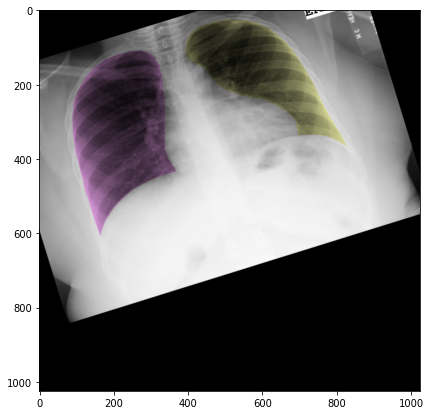

In [9]:
import random
preview(random.choice(dataset_train))

Note that some images have different original dimensions. Some are (4020, 4892) and some are (4892, 4020). 

# seg net

Structure of U-Net is inspired by this paper: https://arxiv.org/abs/1703.08770

But it's not exactly the same. I haven't incorporated residual blocks.

And it looks like there's one giant deconvolution step at the end, instead of having a symmetric looking unet.

TODO: Understand what are "res units" in the UNet ctor, and incorporate those. They are included in the SCAN paper.

In [10]:
seg_net = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=3, # left lung, right lung, background
    channels=(8,8,16,32,64,64),
    strides=(2,2,2,2,2),
    dropout=0.2,
    num_res_units=1
)

num_params = sum(p.numel() for p in seg_net.parameters())
print(f"seg_net has {num_params} parameters")

seg_net has 149734 parameters


In [11]:
seg_net

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.2, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
              (adn): ADN(
                (N): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
                (D): Dropout(p=0.2, inplace=False)
                (A): PReLU(num_parameters=1)
              )
     

# Loss

In [12]:
dice_loss = monai.losses.DiceLoss(
    to_onehot_y = False, # the segs we pass in are already in one-hot form due to MasksToOneHotD defined above
    softmax = True, # Note that our segmentation network is missing the softmax at the end
)

In [13]:
# Test drive the loss function
data_item = dataset_train[42]
seg_pred = seg_net(data_item['img'].unsqueeze(0)) # shape is (1,3,1024,1024), which is (B,N,H,W)

dice_loss(
    seg_net(data_item['img'].unsqueeze(0)), # input, one-hot
    data_item['seg'].unsqueeze(0), # target, one-hot
)

tensor(0.7477, grad_fn=<MeanBackward0>)

# Previewing seg net outputs

In [14]:
import torch

def preview_seg_net(data_item):
    
    seg_net.eval()
    im_device = data_item['img'].to(next(seg_net.parameters()).device.type)
    seg_pred = seg_net(im_device.unsqueeze(0))[0].cpu()
    _, max_indices = seg_pred.max(dim=0)
    seg_pred_mask1 = (max_indices==1).type(torch.int8)
    seg_pred_mask2 = (max_indices==2).type(torch.int8)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,10))
    
    im = data_item['img'].expand((3,)+data_item['img'].shape[1:])
    im = im/im.max()
    
    seg_true = data_item['seg'].float()
    im_true = im.clone()
    im_true[1,:,:] *= 1-0.3*seg_true[1,:,:]
    im_true[2,:,:] *= 1-0.3*seg_true[2,:,:]
    im_true = np.transpose(im_true,axes=(1,2,0))
    ax1.imshow(im_true, cmap='bone')
    ax1.set_title("true seg overlay")
    ax1.axis('off')
    
    ax2.imshow(max_indices)
    ax2.set_title("predicted seg")
    ax2.axis('off')
    
    fig = plt.figure(figsize=(5,5))
    im_pred = im.clone()
    im_pred[1,:,:] *= 1-0.6*seg_pred_mask1
    im_pred[2,:,:] *= 1-0.6*seg_pred_mask2
    im_pred = np.transpose(im_pred,axes=(1,2,0))
    ax3.imshow(im_pred, cmap='bone')
    ax3.set_title("predicted seg overlay")
    ax3.axis('off')
    
    plt.show();
    
    loss = dice_loss(
        seg_pred.unsqueeze(0),
        data_item['seg'].unsqueeze(0),
    )
    print(f"Dice loss: {loss.item()}")

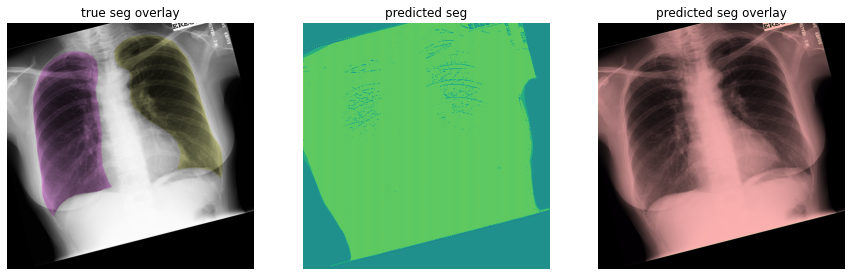

<Figure size 360x360 with 0 Axes>

Dice loss: 0.7554035782814026


In [15]:
# Try seg_net on a random image.
preview_seg_net(random.choice(dataset_train));

# Training

In [ ]:
seg_net.to('cuda')

dataloader_train = monai.data.DataLoader(
    dataset_train,
    batch_size=16,
    num_workers=8,
    shuffle=True
)

dataloader_valid = monai.data.DataLoader(
    dataset_valid,
    batch_size=16,
    num_workers=8,
    shuffle=False
)

learning_rate = 1e-3
optimizer = torch.optim.Adam(seg_net.parameters(), learning_rate)

max_epochs = 60
training_losses = [] 
validation_losses = []

for epoch_number in range(max_epochs):
    
    seg_net.train()
    losses = []
    for batch in dataloader_train:
        imgs = batch['img'].to('cuda')
        true_segs = batch['seg'].to('cuda')

        optimizer.zero_grad()
        predicted_segs = seg_net(imgs)
        loss = dice_loss(predicted_segs, true_segs)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    training_loss = np.mean(losses)
    
    seg_net.eval()
    losses = []
    with torch.no_grad():
        for batch in dataloader_valid:
            imgs = batch['img'].to('cuda')
            true_segs = batch['seg'].to('cuda')
            predicted_segs = seg_net(imgs)
            loss = dice_loss(predicted_segs, true_segs)
            losses.append(loss.item())
        validation_loss = np.mean(losses)
        
    print(f"Epoch {epoch_number+1}/{max_epochs}\n\ttraining loss: {training_loss}\n\tvalidation loss: {validation_loss}")
    training_losses.append(training_loss)
    validation_losses.append(validation_loss)

Epoch 1/60
	training loss: 0.7455345051629203
	validation loss: 0.7272327244281769
Epoch 2/60
	training loss: 0.7166487574577332
	validation loss: 0.69687220454216
Epoch 3/60
	training loss: 0.6883224844932556
	validation loss: 0.6797516644001007
Epoch 4/60
	training loss: 0.677987379687173
	validation loss: 0.6729671955108643


In [ ]:

torch.cuda.empty_cache()

In [ ]:
preview_seg_net(random.choice(dataset_valid))

In [ ]:
plt.plot(training_losses, label="training")
plt.plot(validation_losses, label="validation")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('mean dice loss')
plt.show()

In [ ]:
# CHECKPOINT CELL; SAVE
# torch.save(seg_net.state_dict(),'seg_net3.pth')

In [ ]:
# CHECKPOINT CELL; LOAD
# seg_net.load_state_dict(torch.load('seg_net3.pth'))